In [ ]:
import os
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch import tensor
from utils.load_folktables import prepare_folktables, prepare_folktables_multattr
from humancompatible.train.constraints.constraint_fns import *
from fairret.statistic import *
from utils.network import SimpleNet

This notebook presents some useful plots based on the performance of the trained models.

### **Preparation**

**Load the Folktables dataset for the selected state and prepare it for usage**

In [ ]:
TASK = "income"
# TASK = 'employment'
STATE = "OK"

In [ ]:
(
    X_train,
    y_train,
    group_ind_train,
    sep_group_ind_train,
    X_test,
    y_test,
    group_ind_test,
    sep_group_ind_test,
) = prepare_folktables_multattr(
    TASK,
    state=STATE.upper(),
    random_state=42,
    onehot=False,
    download=True,
    sens_cols=[
        "MAR",
        # 'RAC1P',
        # 'SEX',
    ],
    binarize=[None],
    stratify=False,
)

In [ ]:
device = "cuda" if torch.cuda.is_available() and False else "cpu"

In [ ]:
X_train_tensor = tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = tensor(y_train, dtype=torch.float, device=device)

X_test_tensor = tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = tensor(y_test, dtype=torch.float, device=device)

**Load saved models**

In [ ]:
from itertools import product

constraints = {
    'abs_loss_equality': 0.05,
    # "loss_equality": 0.005,
    "unconstrained": None,
}

dict_alg_names = {
    "StochasticGhost": "StGh",
    "ALM": "ALM",
    "SSLALM": "SSL-ALM",
    "SSG": "SSw",
    "SGD": "SGD",
    "fairret": "SGD-Fairret",
}

DATASET = TASK + "_" + STATE
loaded_models = []

for constr, cb in constraints.items():
    DIRECTORY_PATH = (
        "./utils/saved_models/" + DATASET + "/" + constr + "/" + ((f"{cb:.0E}" + "/") if cb is not None else '')
    )
    FILE_EXT = ".pt"

    directory_path = DIRECTORY_PATH
    print(f"Looking for models in: {directory_path}")
    try:
        file_list = os.listdir(directory_path)
    except FileNotFoundError:
        print("Not found")
        continue
    model_files = [file for file in file_list if file.endswith(FILE_EXT)]
    for model_file in model_files:
        if model_file.split("_")[0] not in dict_alg_names.keys():
            continue
        model_name = model_file
        model = SimpleNet(X_test.shape[1], 1, torch.float32).to(device)
        print(model_file)
        try:
            model.load_state_dict(
                torch.load(
                    directory_path + model_name, weights_only=False, map_location=device
                )
            )
        except:
            continue
        loaded_models.append((model_file, model))


Looking for models in: ./utils/saved_models/income_OK/abs_loss_equality/5E-02/
SSLALM_0.05_trial2.pt
SSG_0.05_trial1.pt
SSG_0.05_trial0.pt
SSG_0.05_trial2.pt
SSLALM_0.05_trial0.pt
SGD_0.05_trial1.pt
SGD_0.05_trial0.pt
SSLALM_0.05_trial1.pt
SGD_0.05_trial2.pt
Looking for models in: ./utils/saved_models/income_OK/unconstrained/
Not found


### **Evaluation**

**Calculate test set statistics for the models - AUC, constraint satisfaction, loss, etc.. and aggregate per algorithm:**

In [ ]:
from utils.stats import make_pairwise_constraint_stats_table, aggregate_model_stats_table, make_groupwise_stats_table

**Train set**:

In [ ]:
full_data_stats = make_groupwise_stats_table(
    X_train_tensor,
    y_train_tensor,
    loaded_models
    ).drop('Model',axis=1).groupby('Algorithm').agg('mean')

groupwise_stats = []

for group_ind in group_ind_train:
    groupwise_stats.append(
        make_groupwise_stats_table(
            X_train_tensor[group_ind],
            y_train_tensor[group_ind],
            loaded_models
        ).drop('Model',axis=1).groupby('Algorithm').agg('mean')
    )

In [ ]:
groupwise_dev = []

for group_stats in groupwise_stats:
    diff = full_data_stats - group_stats
    diff = diff.add_suffix('_dev')
    diff['sep'] = abs(diff['tpr_dev']) + abs(diff['fpr_dev'])
    diff['suf'] = abs(diff['ppv_dev']) + abs(diff['fomr_dev'])
    diff['ind'] = abs(diff['pr_dev'])
    groupwise_dev.append(diff)


In [ ]:
groupwise_dev[0]

,acc_dev,auc_dev,fpr_dev,tpr_dev,ppv_dev,fomr_dev,pr_dev,sep,suf,ind
Algorithm,,,,,,,,,,
SGD_0.05,0.089028,0.050942,-0.05765,0.008275,0.070878,-0.021486,-0.038565,0.065925,0.092365,0.038565
SSG_0.05,0.091243,0.038198,-0.040665,0.007508,0.071742,-0.014753,-0.024115,0.048172,0.086495,0.024115
SSLALM_0.05,0.077784,0.025051,-0.046424,0.015334,0.05532,-0.021546,-0.024532,0.061758,0.076866,0.024532


In [ ]:
from itertools import combinations
import pandas as pd

bin_dfs = []

for group_idx_1, group_idx_2 in list(combinations(group_ind_train, 2)):
    X_train_1, y_train_1 = X_train_tensor[group_idx_1], y_train_tensor[group_idx_1]
    X_train_2, y_train_2 = X_train_tensor[group_idx_2], y_train_tensor[group_idx_2]
    table = make_pairwise_constraint_stats_table(
        X_train_1, y_train_1, X_train_2, y_train_2, loaded_models
    )
    table.index = table.Algorithm.apply(lambda x: dict_alg_names[x.split("_")[0]])
    table.drop("Algorithm", axis=1, inplace=True)
    bin_dfs.append(table)
    
df_train = pd.concat(bin_dfs, axis=0, keys=range(len(bin_dfs)), names=["constraint"])

In [ ]:
train_df = aggregate_model_stats_table(
    df_train, "mean", agg_cols=["constraint", "Algorithm"]
)
train_df_std = aggregate_model_stats_table(
    df_train, ["mean", "std"], agg_cols=["constraint", "Algorithm"]
)
train_df_std.drop("Algname", axis=1, inplace=True)

In [ ]:
train_df

AUC_M       Ind        Sp       Ina        Sf  \
constraint Algorithm                                                     
0          SGD        0.531348  0.212362  0.456731  0.441992  0.119778   
           SSL-ALM    0.503102  0.248774  0.511068  0.471946  0.103545   
           SSw        0.473928  0.130595   0.28876  0.433705  0.101712   
1          SGD        0.500187  0.021458  0.055213  0.431653  0.179488   
           SSL-ALM    0.468961  0.051626  0.108586  0.463143  0.174308   
           SSw        0.451251  0.008299  0.065212  0.416965  0.131952   
2          SGD        0.476562  0.117095  0.202113  0.434921  0.330383   
           SSL-ALM    0.447452  0.100986  0.202023  0.464227  0.366404   
           SSw        0.427865  0.087526  0.153202  0.428045  0.310123   
3          SGD        0.537210  0.166253  0.227662  0.344877  0.425426   
           SSL-ALM    0.491618  0.134194  0.180222  0.382975  0.477766   
           SSw        0.475938  0.094067  0.139844  0.344450  0.465931   
4          SGD        0.533502  0.190904  0.401996  0.402185  0.062406   
           SSL-ALM    0.499790  0.197148  0.402482  0.448613  0.070763   
           SSw        0.478295  0.134438   0.27368  0.353888  0.055646   
5          SGD        0.509877  0.329457  0.658844  0.370479  0.210605   
           SSL-ALM    0.478280   0.34976  0.713091  0.426686  0.262859   
           SSw        0.454909  0.218121  0.441962  0.334800  0.233816   
6          SGD        0.570525  0.378615  0.684394  0.176912  0.305647   
           SSL-ALM    0.522447  0.382968  0.687683  0.234710  0.374221   
           SSw        0.502981  0.224661  0.428604  0.183169  0.389625   
7          SGD        0.478716  0.138553  0.256848  0.374380  0.150895   
           SSL-ALM    0.444140  0.152612  0.310609  0.419185  0.192096   
           SSw        0.432232  0.083683  0.168282  0.329424   0.17817   
8          SGD        0.539364  0.187711  0.282398  0.229659  0.245938   
           SSL-ALM    0.488306   0.18582  0.285201  0.282675  0.303458   
           SSw        0.480305  0.090223  0.154924  0.221264  0.333979   
9          SGD        0.515739  0.049158  0.082676  0.156571  0.113456   
           SSL-ALM    0.466797  0.033209  0.119059  0.213782  0.116139   
           SSw        0.456919   0.00654  0.028376  0.165946  0.155809   

                            Wd  |Loss_0 - Loss_1| |TPR_0 - TPR_1|  acc_diff  \
constraint Algorithm                                                          
0          SGD        0.028086           0.164185        0.271619  0.019437   
           SSL-ALM    0.015389           0.021990        0.281561  0.042846   
           SSw        0.018770           0.154137         0.18627  0.028602   
1          SGD        0.000467           0.130691        0.041805  0.049630   
           SSL-ALM    0.001220           0.044269        0.070801  0.034344   
           SSw        0.001172           0.153962        0.040146  0.091872   
2          SGD        0.007667           0.244945        0.073959  0.182810   
           SSL-ALM    0.001341           0.131952        0.086583  0.159564   
           SSw        0.002882           0.264968        0.049613  0.197134   
3          SGD        0.019943           0.506400        0.046459  0.292508   
           SSL-ALM    0.002958           0.247994        0.017957  0.263363   
           SSw        0.007170           0.461449        0.028762  0.274514   
4          SGD        0.022626           0.033495        0.229814  0.061431   
           SSL-ALM    0.008359           0.022279         0.21076  0.077190   
           SSw        0.012326           0.015887        0.146124  0.063269   
5          SGD        0.058403           0.080760        0.345578  0.194611   
           SSL-ALM    0.021735           0.109963        0.368144  0.202410   
           SSw        0.029450           0.110830        0.235883  0.168532   
6          SGD        0.085097           0.342215        0.318078  0.304308 

**Plots:**

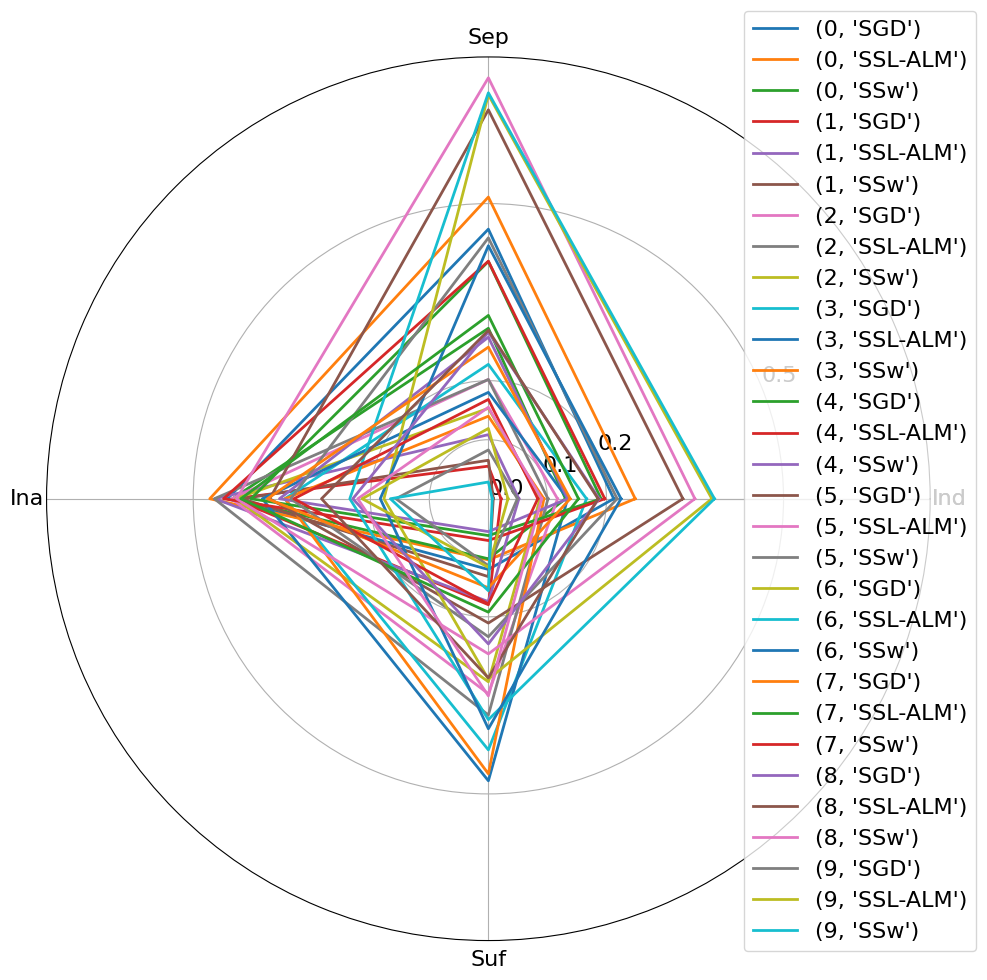

In [ ]:
from utils.plotting import spider_line


f = spider_line(train_df, yticks=[0,0.1,0.2,0.5])

**Distribution of predictions by group:**

In [ ]:
predictions_by_alg = {alg: {} for alg in set([model_name.split("_")[0] for model_name, _ in loaded_models])}


for i, group in enumerate(group_ind_test):
    for model_name, model in loaded_models:
        alg = model_name.split("_")[0]

        preds = torch.nn.functional.sigmoid(model(X_test_tensor[group])).detach().numpy().squeeze()
        try:
            predictions_by_alg[alg][i].append(preds)
        except:
            predictions_by_alg[alg][i] = [preds]

for alg in predictions_by_alg.keys():
    for i in predictions_by_alg[alg].keys():
        predictions_by_alg[alg][i] = np.concatenate(predictions_by_alg[alg][i])

In [ ]:
pred_dfs = {}

for alg, pred_dict in predictions_by_alg.items():
    preds = []
    groups = []
    for group, group_preds in pred_dict.items():
        preds.extend(group_preds)
        groups.extend([group]*len(group_preds))
    
    pred_dfs[alg] = (
        pd.DataFrame({'pred': preds, 'group': groups})
    )

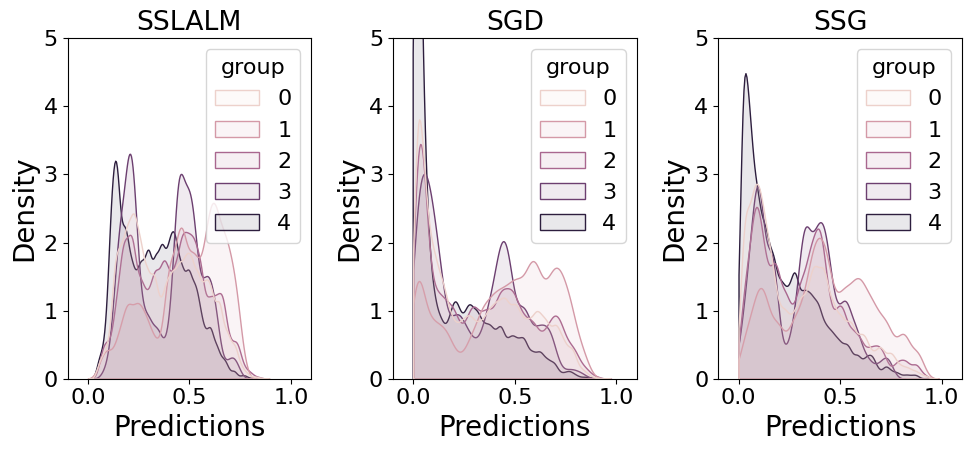

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=3)

for i, (alg, predictions) in enumerate(pred_dfs.items()):
    ax = axs[i]
    sns.kdeplot(
        predictions,
        x='pred',
        hue='group',
        fill=True,
        alpha=0.1,
        bw_adjust=0.4,
        ax=ax,
        clip=[0,1],
        common_norm=False)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 5)
    ax.set_xlabel("Predictions", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    ax.set_title(alg)

fig.set_figwidth(10)
fig.tight_layout()

### **Model plots**

**We choose one model per algorithm to make some useful plots**

For now, choose the model with the highest mean AUC:

In [ ]:
df_train.index.get_level_values('Algorithm').unique()

Index(['SSL-ALM', 'SSw', 'SGD'], dtype='object', name='Algorithm')

In [ ]:
select_by = "AUC_M"

In [ ]:
best_models = {}
algs = df_train.index.get_level_values('Algorithm').unique()
for alg in algs:
    alg_df = df_train.xs(alg, level=1).reset_index()
    best_model_name = alg_df[['Model', select_by]].groupby('Model').mean()[select_by].idxmax()
    model = [(name, model) for name, model in loaded_models if name == best_model_name][0]
    best_models[alg] = model

#### Subgroup ROC

**TPR-FPR plot**

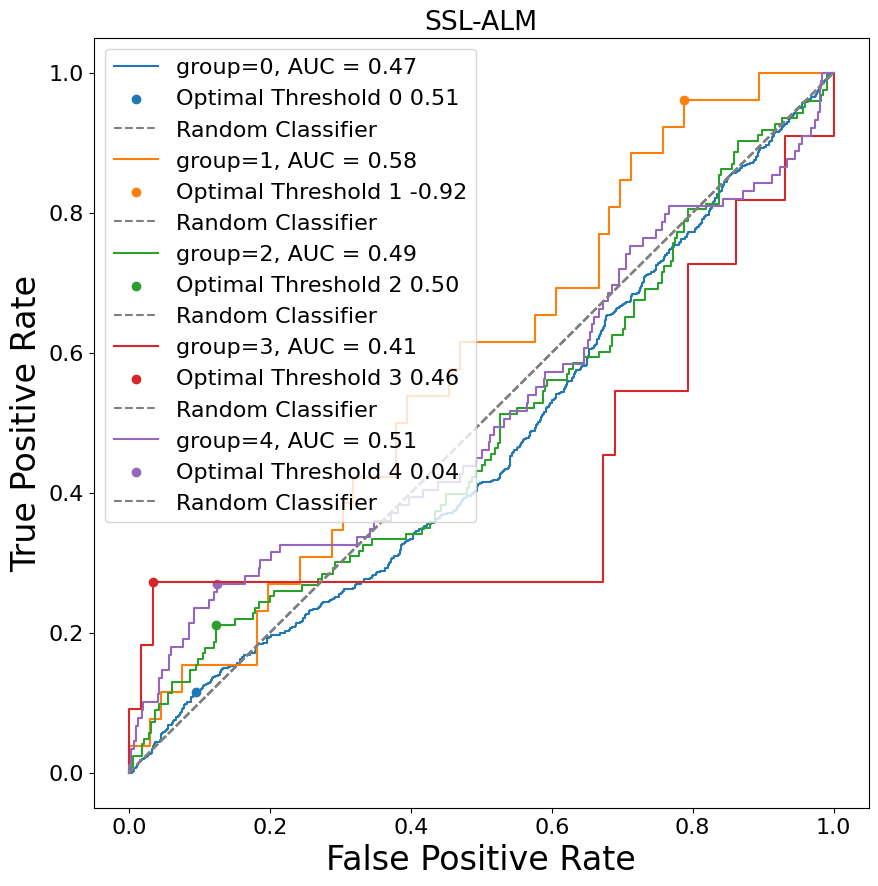

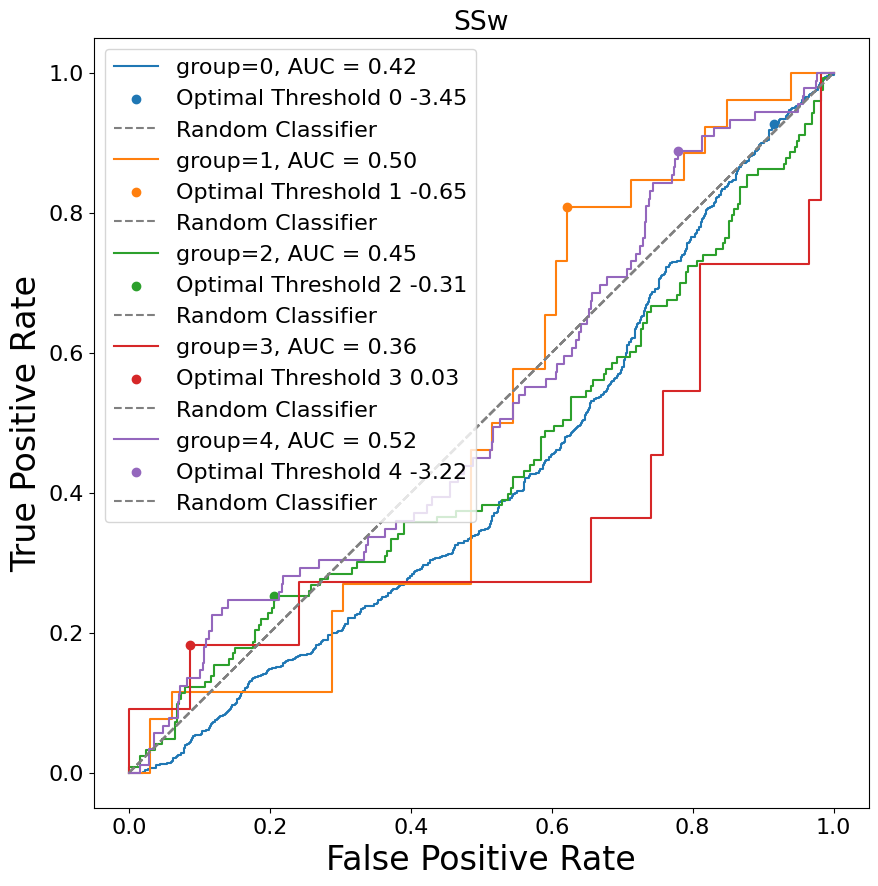

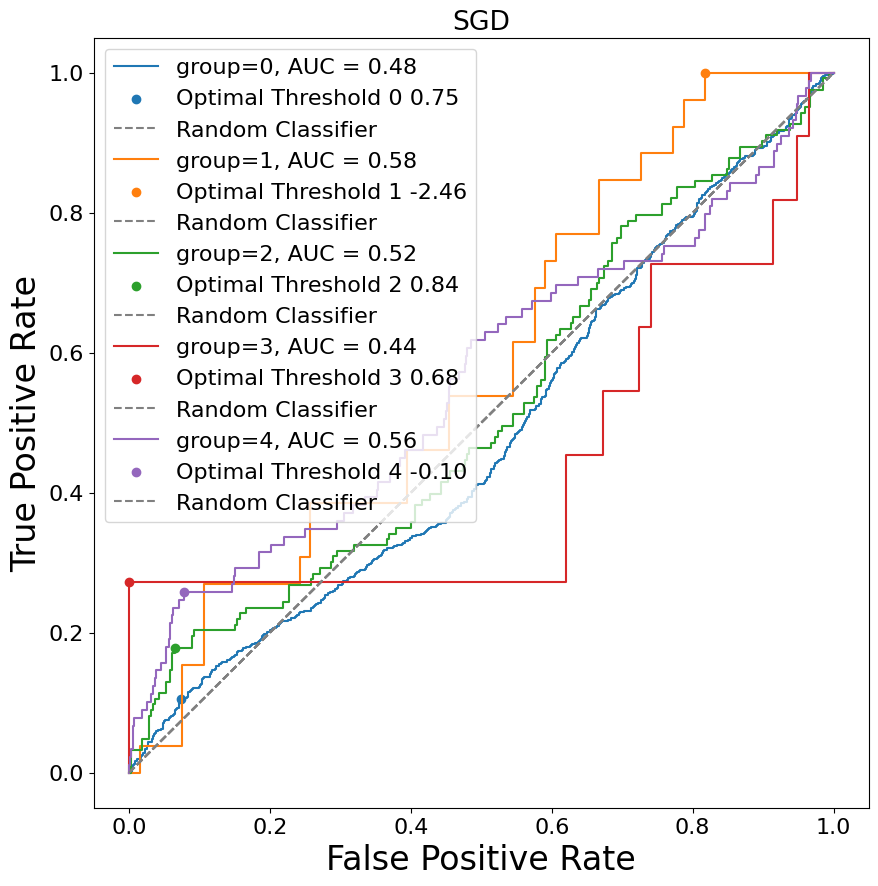

In [ ]:
# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(ax, predictions, targets, sensitive_value):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f"group={sensitive_value}, AUC = {roc_auc:.2f}")
    tpr_minus_fpr = tpr - fpr
    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        fpr[optimal_threshold_index],
        tpr[optimal_threshold_index],
        # c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        for i,group in enumerate(group_ind_test):
            predictions = model(X_test_tensor[group])
            # Plot ROC for sensitive attribute A=0
            plot_roc_curve_pr(
                ax, predictions, y_test[group], sensitive_value=i
            )
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
            ax.set_xlabel("False Positive Rate", fontsize=24)
            ax.set_ylabel("True Positive Rate", fontsize=24)
            ax.legend()

**TNR-FNR plot**

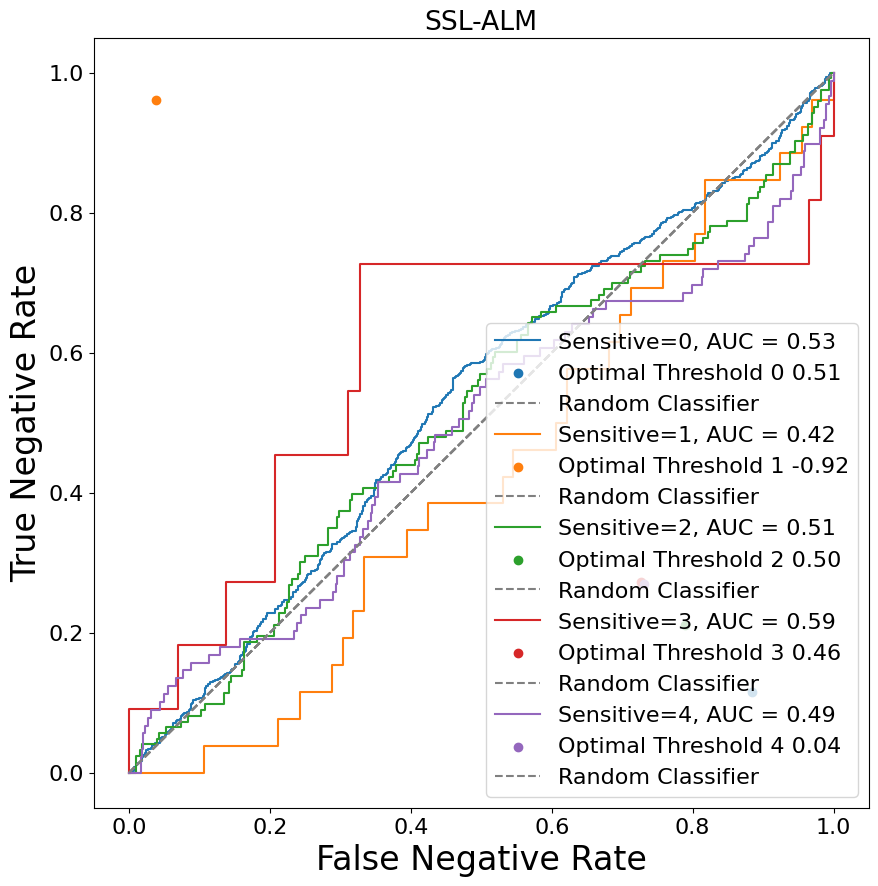

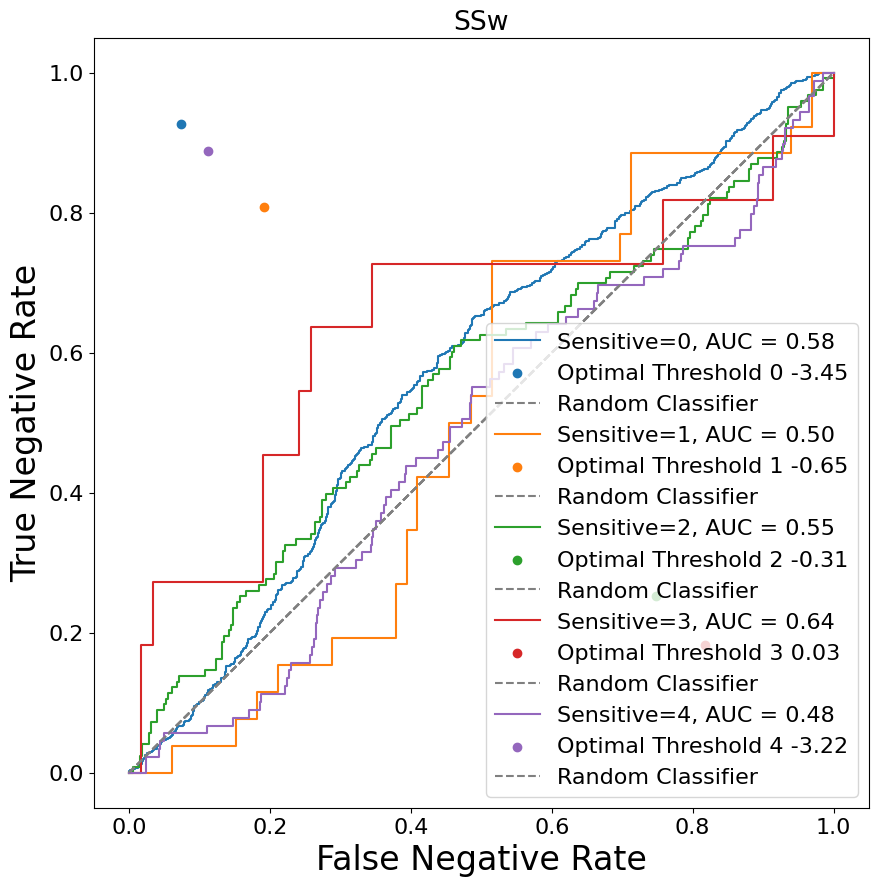

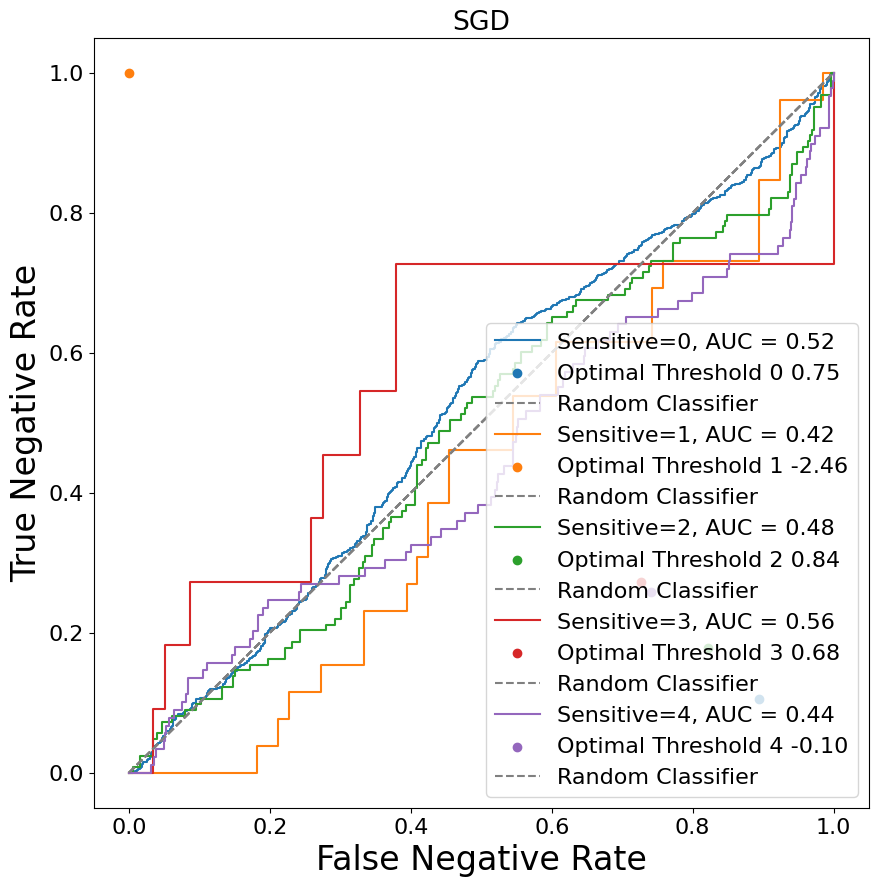

In [ ]:
# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(ax, predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    # predictions = predictions.detach().numpy()
    # targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = 1 - tpr
    tnr = 1 - fpr
    roc_auc = auc(tnr, fnr)
    # Plot ROC curve
    ax.plot(tnr, fnr, label=f"Sensitive={sensitive_value}, AUC = {roc_auc:.2f}")

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes tnr - fnr difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        fnr[optimal_threshold_index],
        tpr[optimal_threshold_index],
        # c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        for i,group in enumerate(group_ind_test):
            predictions = model(X_test_tensor[group])
            # Plot ROC for sensitive attribute A=0
            plot_roc_curve_nr(
                ax, predictions, y_test[group], sensitive_value=i
            )
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
            ax.set_xlabel("False Negative Rate", fontsize=24)
            ax.set_ylabel("True Negative Rate", fontsize=24)
            ax.legend()